In [1]:
import math
import numpy as np

from scipy import signal
from PIL import Image, ImageDraw

In [2]:
!unzip hw2part1.zip

Archive:  hw2part1.zip
   creating: hw2/
  inflating: hw2/.DS_Store           
   creating: __MACOSX/
   creating: __MACOSX/hw2/
  inflating: __MACOSX/hw2/._.DS_Store  
   creating: hw2/faces/
  inflating: hw2/faces/.DS_Store     
   creating: __MACOSX/hw2/faces/
  inflating: __MACOSX/hw2/faces/._.DS_Store  
  inflating: hw2/faces/family.jpg    
  inflating: __MACOSX/hw2/faces/._family.jpg  
  inflating: hw2/faces/fans.jpg      
  inflating: __MACOSX/hw2/faces/._fans.jpg  
  inflating: hw2/faces/judybats.jpg  
  inflating: __MACOSX/hw2/faces/._judybats.jpg  
  inflating: hw2/faces/sports.jpg    
  inflating: __MACOSX/hw2/faces/._sports.jpg  
  inflating: hw2/faces/students.jpg  
  inflating: __MACOSX/hw2/faces/._students.jpg  
  inflating: hw2/faces/template.jpg  
  inflating: __MACOSX/hw2/faces/._template.jpg  
  inflating: hw2/faces/tree.jpg      
  inflating: __MACOSX/hw2/faces/._tree.jpg  
  inflating: __MACOSX/hw2/._faces    
  inflating: hw2/lbpcascade_model.xml  
  inflating: __

In [3]:
from hw2 import ncc

In [4]:
# if num is odd or not integer, round it up
# if num is even, add one
def odd(num):
  if math.ceil(num) % 2 != 0:
    return math.ceil(num)
  else:
    return math.ceil(num) + 1

In [5]:
# gauss = e^(-x^2/(2*sigma^2))
def gauss(x, sigma):
  return math.exp(-pow(x, 2) / (2 * pow(sigma, 2)))

In [6]:
def gauss1d(sigma):
  # determine the length of the x array
  length = odd(sigma * 6)
  x_array = np.arange(-(length-1)/2, (length-1)/2+1, dtype = int)
  # apply the gaussian functino to every element in the x array
  gauss_array = np.array([gauss(x, sigma) for x in x_array])
  # nomalize the gaussian filter so that all the element in the filter add to 1
  gauss_norm_array = gauss_array/np.sum(gauss_array)
  return gauss_norm_array

In [7]:
def gauss2d(sigma):
  # generate a 1d gaussian filter by the sigma
  gauss_1d_array = gauss1d(sigma)
  # generate 2d version based on the 1d gaussian array
  gauss_2d_1d_array = gauss_1d_array[np.newaxis, :]
  # calculate the convolution of gaussian array with its transpose
  gauss_2d_array = signal.convolve2d(gauss_2d_1d_array, np.transpose(gauss_2d_1d_array))
  return gauss_2d_array

In [8]:
def gaussconvolve2d_scipy(array, sigma):
  filter = gauss2d(sigma)
  return signal.convolve2d(array,filter,'same')

In [133]:
def MakeGaussianPyramid(image, scale, minsize):
  # to prevent antialiasing artifacts
  sigma = 1 / (2*scale)
  pyramid = []
  im = Image.open(image)
  if (im.mode == 'L'):
    channel_num = 1
  else:
    channel_num = 3
  larger_dimension = max(im.width, im.height)
  origin_im = im
  while (larger_dimension >= minsize):
    # convert the image to numpy double array
    image_array = np.asarray(origin_im, np.double)

    # append the gaussian filtered float32 array to the output pyramid
    pyramid.append(image_array)

    # generate the gaussian result array
    filtered_image_array = np.ndarray(image_array.shape)

    if channel_num != 1:
      # iterate over the RGB channels of the image and apply the gaussian filter
      for channel in range (0, 3):
        channel_array = image_array[:,:,channel]
        filtered_channel_array = gaussconvolve2d_scipy(channel_array, sigma)
        filtered_image_array[:,:,channel] = filtered_channel_array
    else:
      filtered_image_array = gaussconvolve2d_scipy(image_array, sigma)
    # convert to unsigned int array
    filtered_image_array_int = Image.fromarray(filtered_image_array.astype('uint8'))
    # downsample the image
    origin_im = filtered_image_array_int.resize((int(origin_im.width*scale),int(origin_im.height*scale)), Image.BICUBIC)
    # choose the larger value between width and height to compare with minsize
    larger_dimension = max(origin_im.width, origin_im.height)
  return pyramid

In [134]:
def ShowGaussianPyramid(pyramid):
  blankimage_width = 0
  # height equals the largest image
  blankimage_height = pyramid[0].shape[0]
  # width equals the sum of the images
  for image_array in pyramid:
    blankimage_width += image_array.shape[1]
  # choose canvas based on mode of the image
  if (pyramid[0].ndim == 2):
    image = Image.new("L", (blankimage_width, blankimage_height), color='white')
  else:
    image = Image.new("RGB", (blankimage_width, blankimage_height), color='white')

  offset_x = 0
  offset_y = 0
  # iterate over the array and paste the images
  for image_array in pyramid:
    scaled_image = Image.fromarray(image_array.astype('uint8'))
    image.paste(scaled_image,(offset_x,offset_y))
    offset_x += image_array.shape[1]
  image.save('Gaussian_Pyramid.jpeg', 'jpeg')
  scaled = Image.open('Gaussian_Pyramid.jpeg')
  display(scaled)
  return

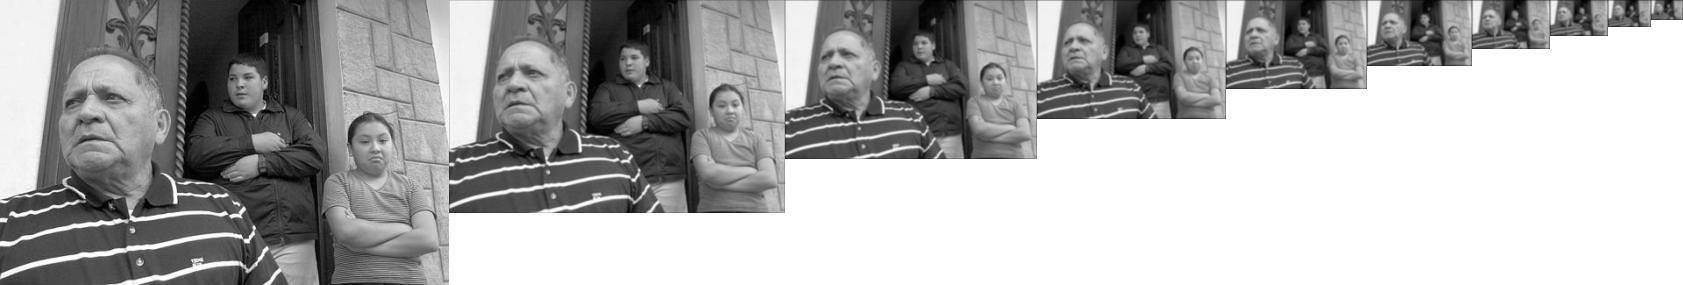

In [135]:
pyramid = MakeGaussianPyramid('hw2/faces/family.jpg', 0.75, 25)
ShowGaussianPyramid(pyramid)

In [136]:
def FindTemplate(pyramid, template, threshold):
  template_im = Image.open(template)
  # downsample the template if it is too big
  if template_im.width > 15:
    scaled_ratio = 15 / template_im.width
    template_im = template_im.resize((15,int(template_im.height*scaled_ratio)), Image.BICUBIC)
  marked_pixel_orign = []
  # compute the normalized correlation of every pixel of every image of the pyramid
  for image_array in pyramid:
    image_array_int = Image.fromarray(image_array.astype('uint8'))
    ncc_array = ncc.normxcorr2D(image_array_int, template_im)
    for ncc_y in range(0, ncc_array.shape[0]):
      for ncc_x in range(0, ncc_array.shape[1]):
        # if it is larger than the threshold, it is identified as a pattern
        if ncc_array[ncc_y, ncc_x] > threshold:
          resized_ratio = image_array.shape[0] / pyramid[0].shape[0]
          marked_pixel_orign.append((int(ncc_x/resized_ratio), int(ncc_y/resized_ratio), resized_ratio))
  # convert the image array to int and then RGB image
  origin_im = Image.fromarray(pyramid[0].astype('uint8'))
  origin_im_rgb = origin_im.convert('RGB')

  draw = ImageDraw.Draw(origin_im_rgb)
  # define the width of the rectangle
  template_x_offset = int(template_im.width / 2)
  #define the height of the rectangle
  template_y_offset = int(template_im.height / 2)
  for pixel in marked_pixel_orign:
    draw.line((pixel[0]-template_x_offset/pixel[2],pixel[1]-template_y_offset/pixel[2],pixel[0]+template_x_offset/pixel[2],pixel[1]-template_y_offset/pixel[2]),fill="red",width=2)
    draw.line((pixel[0]-template_x_offset/pixel[2],pixel[1]-template_y_offset/pixel[2],pixel[0]-template_x_offset/pixel[2],pixel[1]+template_y_offset/pixel[2]),fill="red",width=2)
    draw.line((pixel[0]+template_x_offset/pixel[2],pixel[1]-template_y_offset/pixel[2],pixel[0]+template_x_offset/pixel[2],pixel[1]+template_y_offset/pixel[2]),fill="red",width=2)
    draw.line((pixel[0]-template_x_offset/pixel[2],pixel[1]+template_y_offset/pixel[2],pixel[0]+template_x_offset/pixel[2],pixel[1]+template_y_offset/pixel[2]),fill="red",width=2)
  del draw
  origin_im_rgb.save('marked.jpeg', 'jpeg')
  marked = Image.open('marked.jpeg')
  display(marked)
  return

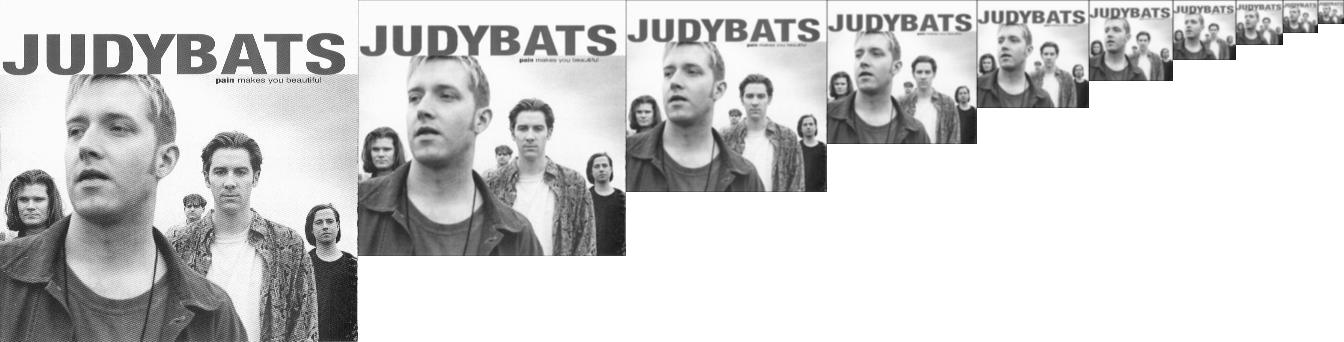

In [137]:
pyramid = MakeGaussianPyramid('hw2/faces/judybats.jpg', 0.75, 25)
ShowGaussianPyramid(pyramid)

/content/hw2/ncc.py:59: RuntimeWarning: divide by zero encountered in divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


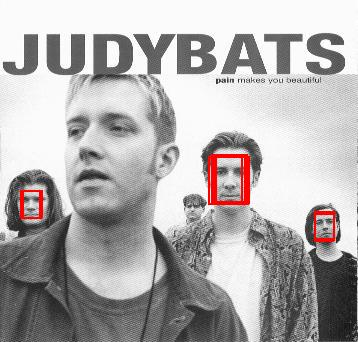

In [138]:
FindTemplate(pyramid, 'hw2/faces/template.jpg', 0.7)

In [139]:
def face_detection(image, template, threshold):
  pyramid = MakeGaussianPyramid(image, 0.75, 25)
  FindTemplate(pyramid, template, threshold)

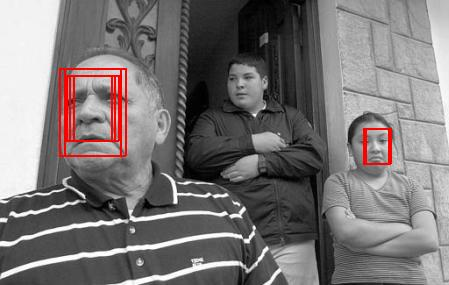

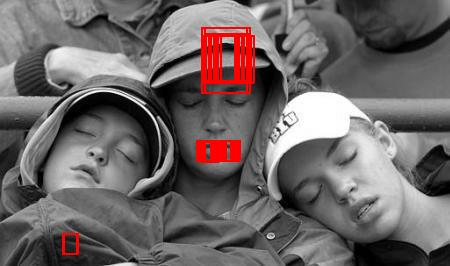

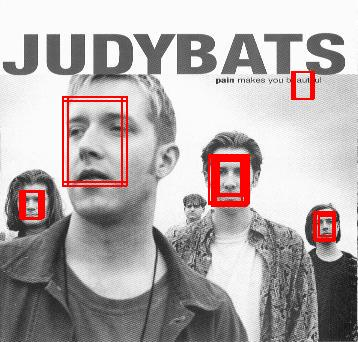

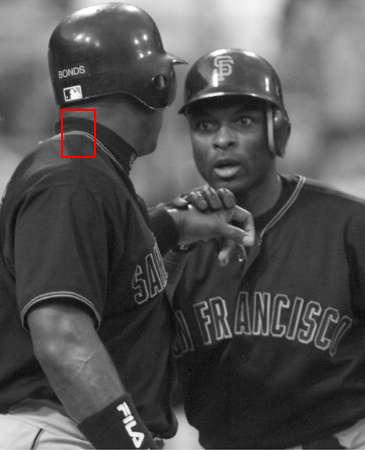

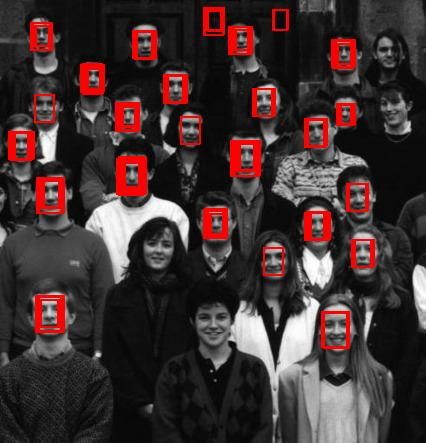

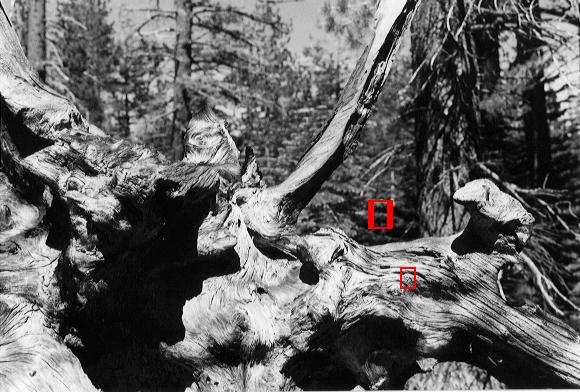

In [140]:
threshold = 0.6
face_detection('hw2/faces/family.jpg', 'hw2/faces/template.jpg', threshold)
face_detection('hw2/faces/fans.jpg', 'hw2/faces/template.jpg', threshold)
face_detection('hw2/faces/judybats.jpg', 'hw2/faces/template.jpg', threshold)
face_detection('hw2/faces/sports.jpg', 'hw2/faces/template.jpg', threshold)
face_detection('hw2/faces/students.jpg', 'hw2/faces/template.jpg', threshold)
face_detection('hw2/faces/tree.jpg', 'hw2/faces/template.jpg', threshold)

```markdown
 images   |false positive     | false negative
----------|-------------------|------------------
 family   |        0          |       1
 fans     |        4          |       3
 judybats |        1          |       1
 sports   |        1          |       1
 students |        2          |       4
 tree     |        2          |       0
 total    |       10          |      10
```

recall rate = relevant retrieved elemets / all relevant elements = (2+4+23) / (2+4+23+10) = 74.4%
```markdown
 images   | recall rate      
----------|--------------
 family   |        100%      
 fans     |        0        
 judybats |        80%      
 sports   |        0      
 students |        92%         
 tree     |        undefined         
```
The recall rate is very low for some images because it cannot identify some transformed version of the pattern. For example, it is hard for the ncc algorithm to recognize someone who closes his eyes, someone wearing a helmet or hat, or someone who has a different hair style that covers some part of the forehead.

In [141]:
!unzip hw2part2.zip

Archive:  hw2part2.zip
replace apple.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [146]:
def MakeLaplacianPyramid(image, scale, minsize):
  channel_num = 3
  # to prevent antialiasing artifacts
  sigma = 1 / (2*scale)
  pyramid = []
  im = Image.open(image)
  larger_dimension = max(im.width, im.height)
  origin_im = im
  # choose different route when the mode of the image is different
  if (im.mode == 'L'):
    channel_num = 1
  else:
    channel_num = 3
  while (larger_dimension >= minsize):
    # convert the image to numpy double array
    image_array = np.asarray(origin_im, np.double)

    # generate the gaussian and laplacian result array
    filtered_image_array = np.ndarray(image_array.shape)
    laplacian_image_array = np.ndarray(image_array.shape)

    if channel_num != 1:
      # iterate over the RGB channels of the image and apply the gaussian filter
      for channel in range (0, 3):
        channel_array = image_array[:,:,channel]
        filtered_channel_array = gaussconvolve2d_scipy(channel_array, sigma)
        filtered_image_array[:,:,channel] = filtered_channel_array
    else:
      filtered_image_array = gaussconvolve2d_scipy(image_array, sigma)

    # convert to unsigned int array and then downsample the image
    filtered_image_array_int = Image.fromarray(filtered_image_array.astype('uint8'))
    origin_im = filtered_image_array_int.resize((int(origin_im.width*scale),int(origin_im.height*scale)), Image.BICUBIC)

    # upsample the downsampled image to calculate the residual
    upsample_im = origin_im.resize((int(image_array.shape[1]), int(image_array.shape[0])), Image.BICUBIC)
    upsample_image_array = np.asarray(upsample_im, np.double)
    if channel_num != 1:
      # iterate the rgb channels to compute the residual between the original image and the upsampled downsampled smoothed image
      for channel in range (0, 3):
        channel_array = image_array[:,:,channel]
        upsample_channel_array = upsample_image_array[:,:,channel]
        laplacian_image_array[:,:,channel] = channel_array - upsample_channel_array
    # choose the larger side of the image to compare with the minsize
    larger_dimension = max(origin_im.width, origin_im.height)
    # if it is the last image on the pyramid, append the blurred image array of the last calculation
    # if it is not the last image on the pyramid, append the residual image array
    if (larger_dimension >= minsize):
      pyramid.append(laplacian_image_array)
    else:
      pyramid.append(filtered_image_array)
  return pyramid

In [147]:
def ShowLaplacianPyramid(pyramid):
  blankimage_width = 0
  # the height of the canvas is the height of the largest image
  blankimage_height = pyramid[0].shape[0]
  # the width of the canvas is the sum of all the images
  for image_array in pyramid:
    blankimage_width += image_array.shape[1]
  # create the canvas
  image = Image.new("RGB", (blankimage_width, blankimage_height), color='white')
  offset_x = 0
  offset_y = 0
  # iterate over the pyramid to paste the images on the canvas
  for i in range(0, len(pyramid) - 1):
    # clip the image to 0-255
    clipped_image_array = np.clip((pyramid[i] + 128.0), 0.0, 255.0)
    scaled_image = Image.fromarray(clipped_image_array.astype('uint8'))
    image.paste(scaled_image,(offset_x,offset_y))
    offset_x += pyramid[i].shape[1]
  # for the last image, there is no need to clip it
  scaled_image = Image.fromarray(pyramid[len(pyramid) - 1].astype('uint8'))
  image.paste(scaled_image,(offset_x,offset_y))
  image.save('laplacian_pyramid.jpeg', 'jpeg')
  scaled = Image.open('laplacian_pyramid.jpeg')
  display(scaled)
  return

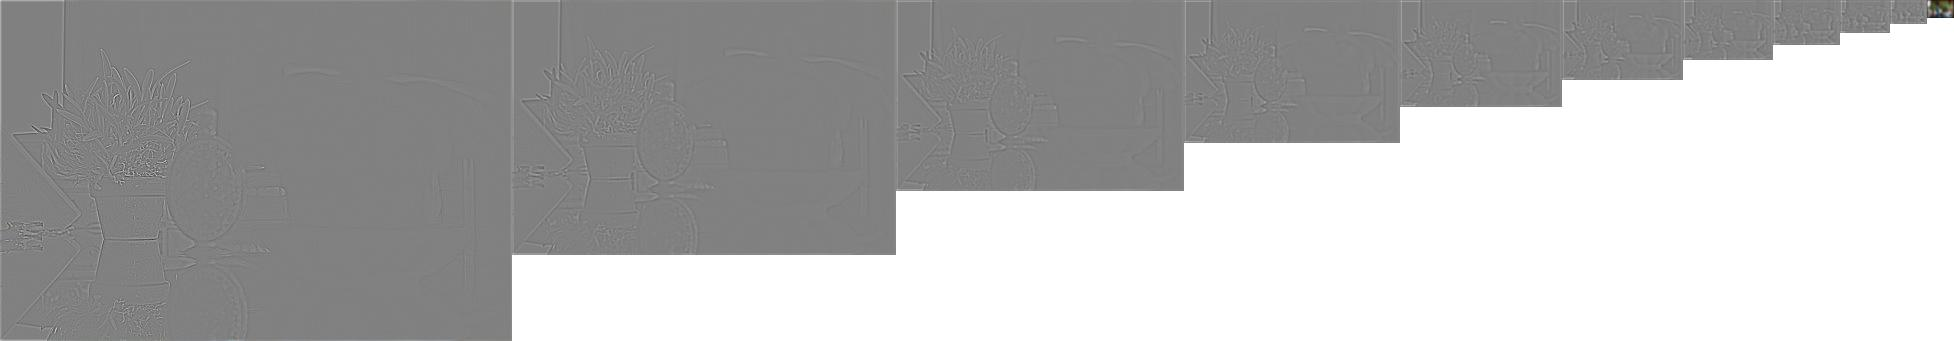

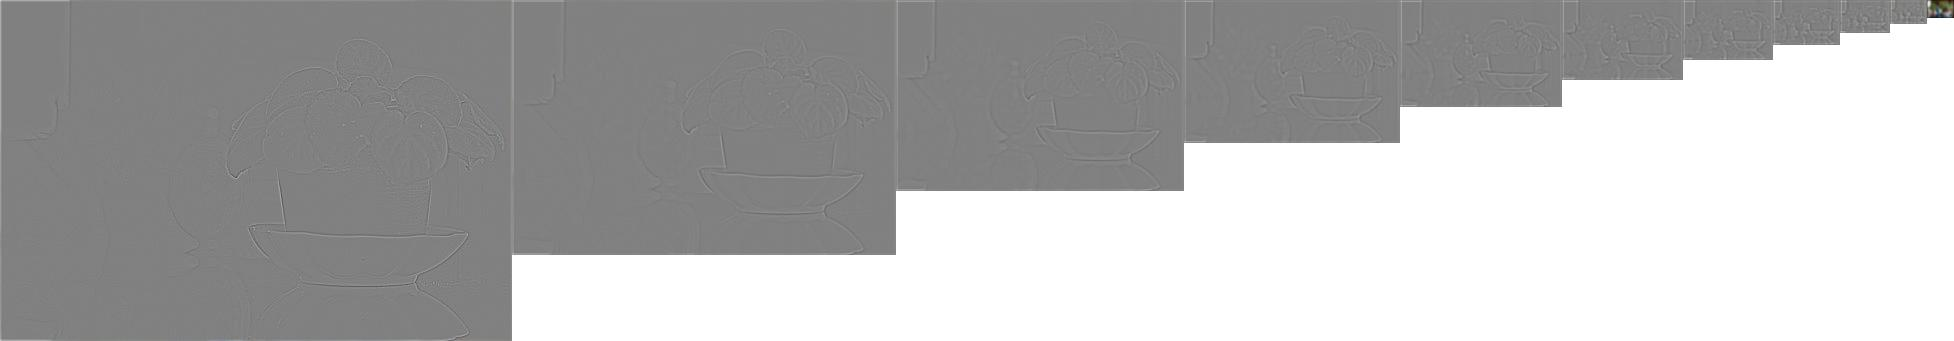

In [148]:
pyramid = MakeLaplacianPyramid('orchid.jpg', 0.75, 25)
ShowLaplacianPyramid(pyramid)
pyramid = MakeLaplacianPyramid('violet.jpg', 0.75, 25)
ShowLaplacianPyramid(pyramid)

In [162]:
def ReconstructGaussianFromLaplacianPyramid(lPyramid):
  # create a gaussian pyramid array
  gPyramid = [None] * len(lPyramid)
  # paste the last image from laplacian pyramid to gaussian pyramid
  gPyramid[len(lPyramid)-1] = lPyramid[len(lPyramid)-1]
  # compute the scale
  scale = lPyramid[1].shape[0] / lPyramid[0].shape[0]
  sigma = 1 / (2*scale)
  # iterate over the gaussian pyramid in a reverse order
  for i in range(len(lPyramid)-1, 0, -1):
    l_image_array_int = Image.fromarray(gPyramid[i].astype('uint8'))
    # upsample the image in the laplacian pyramid
    upsample_im = l_image_array_int.resize((lPyramid[i-1].shape[1],lPyramid[i-1].shape[0]), Image.BICUBIC)
    upsample_image_array = np.asarray(upsample_im, np.double)
    # clip the upsampled image
    clipped_upsample_image_array = np.clip(upsample_image_array, 0.0, 255.0)
    # add the upsamped image with image at next level on the laplacian pyramid
    gPyramid[i-1] = clipped_upsample_image_array + lPyramid[i-1]
  return gPyramid

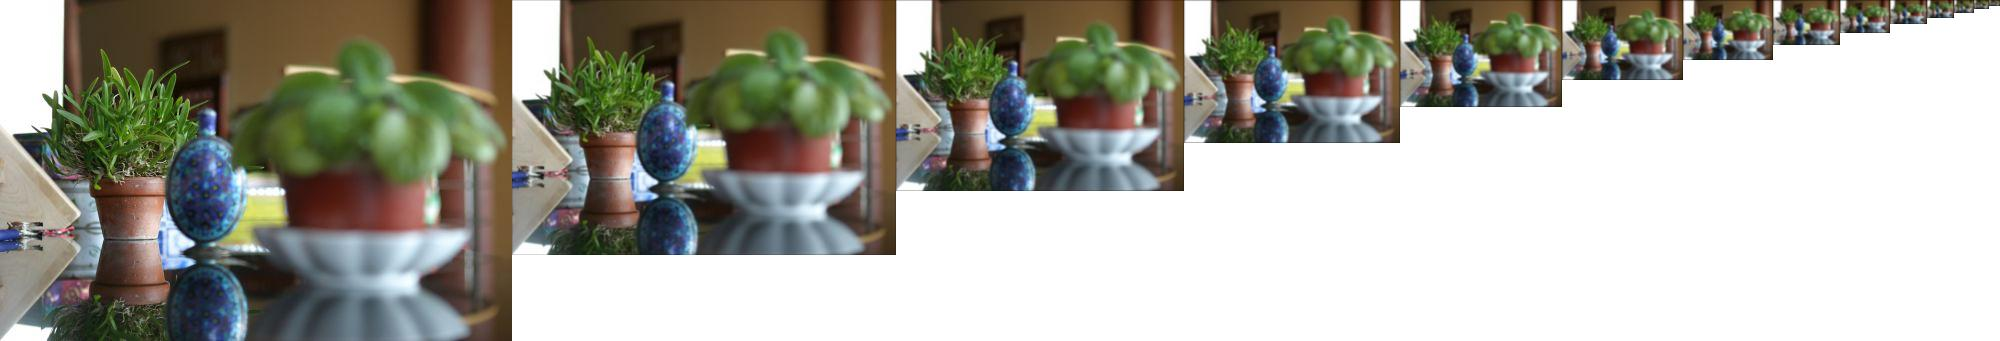

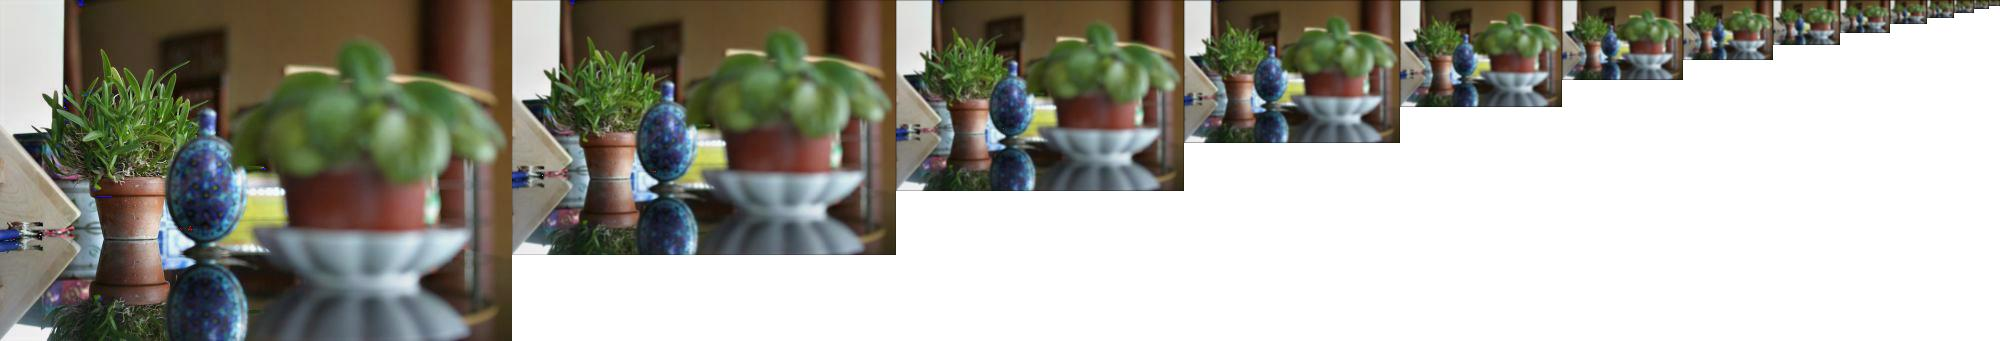

In [163]:
g_pyramid = MakeGaussianPyramid('orchid.jpg', 0.75, 10)
ShowGaussianPyramid(g_pyramid)
l_pyramid = MakeLaplacianPyramid('orchid.jpg', 0.75, 10)
r_pyramid = ReconstructGaussianFromLaplacianPyramid(l_pyramid)
ShowGaussianPyramid(r_pyramid)

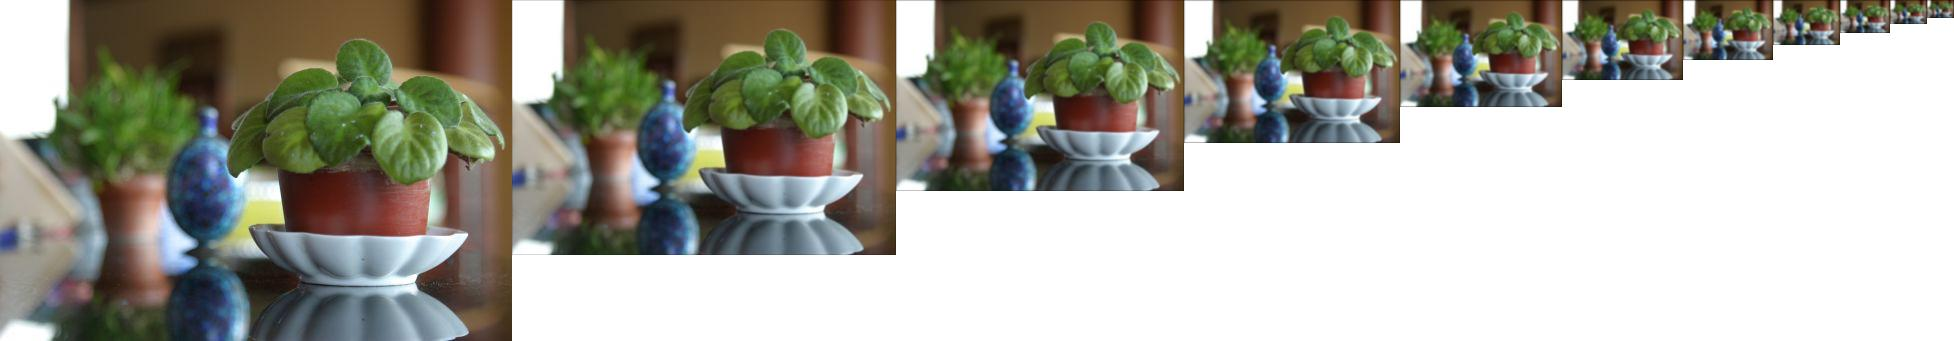

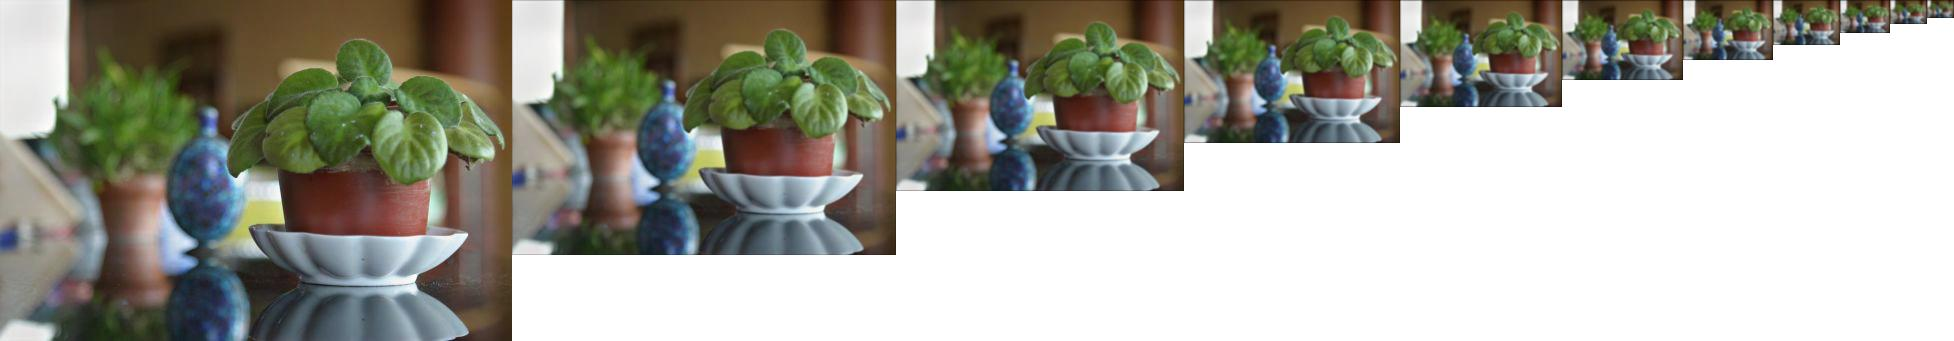

In [164]:
g_pyramid = MakeGaussianPyramid('violet.jpg', 0.75, 25)
ShowGaussianPyramid(g_pyramid)
l_pyramid = MakeLaplacianPyramid('violet.jpg', 0.75, 25)
r_pyramid = ReconstructGaussianFromLaplacianPyramid(l_pyramid)
ShowGaussianPyramid(r_pyramid)

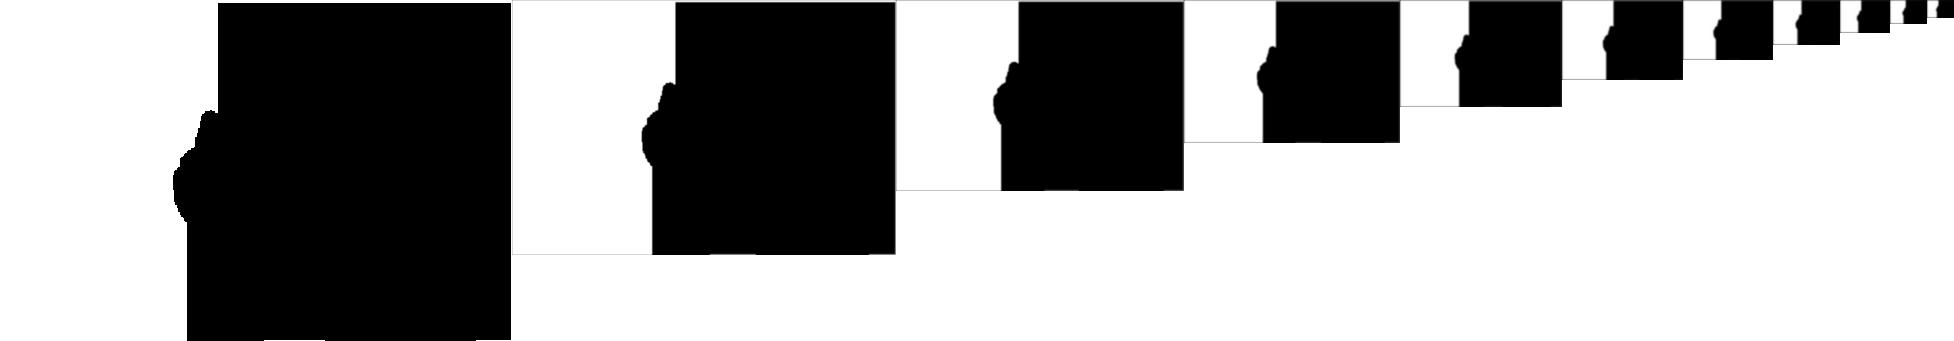

In [165]:
pyramid = MakeGaussianPyramid('orchid_mask.bmp', 0.75, 25)
ShowGaussianPyramid(pyramid)

In [166]:
def ComposePyramid(pyramid1, pyramid2, mask):
  # create a composed laplacian pyramid
  comlaplacian_pyramid = pyramid1
  # iterate over the pyramids to compose them with the mask
  for i in range(0, len(pyramid1)):
    for channel in range (0, 3):
      channel1 = pyramid1[i][:,:,channel]
      channel2 = pyramid2[i][:,:,channel]
      comlaplacian_pyramid[i][:,:,channel] = (mask[i]/255.0)*channel1 + (1-mask[i]/255.0)*channel2
  return comlaplacian_pyramid

In [168]:
def blend_images(image1, image2, mask, scale, minsize):
  # compute the laplacian pyramids for the images
  l_pyramid_v = MakeLaplacianPyramid(image1, scale, minsize)
  l_pyramid_o = MakeLaplacianPyramid(image2, scale, minsize)
  # compute the gaussian pyramid for the mask
  pyramid_mask = MakeGaussianPyramid(mask, scale, minsize)
  # combine the pyramids
  combine_pyramid = ComposePyramid(l_pyramid_o, l_pyramid_v, pyramid_mask)
  # reconstruct a gaussian pyramid based on the laplacian pyramid
  g_com_pyramid = ReconstructGaussianFromLaplacianPyramid(combine_pyramid)
  # show the image with the highest resolution on the pyramid
  Image.fromarray(np.clip(g_com_pyramid[0], 0.0, 255.0).astype('uint8')).save('com_reconstructed.jpeg', 'jpeg')
  recon_im = Image.open('com_reconstructed.jpeg')
  display(recon_im)

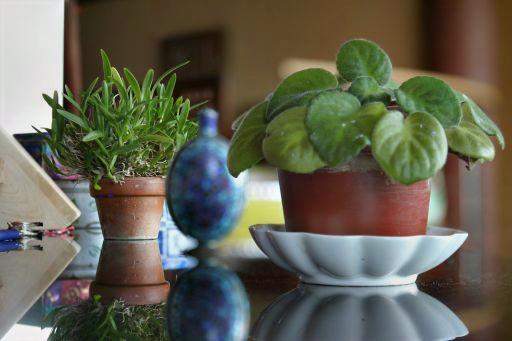

In [169]:
blend_images('violet.jpg', 'orchid.jpg', 'orchid_mask.bmp', 0.75, 10)

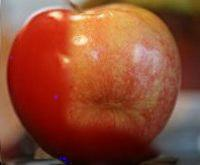

In [170]:
blend_images('apple.jpg', 'tomato.jpg', 'tomato_mask.bmp', 0.75, 30)

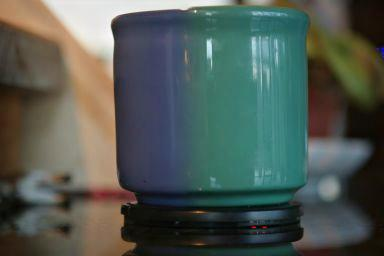

In [171]:
blend_images('green_cup.jpg', 'blue_cup.jpg', 'cup_mask.bmp', 0.75, 25)